# Daily Rain Reports


In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
import contextily as cx

from raindownloader.inpeparser import INPE, INPEParsers, INPETypes
from raindownloader.downloader import Downloader
from raindownloader.utils import FileType
from rainreporter.reporter import Reporter
from rainreporter.mapper import Mapper
from rainreporter.daily_report import DailyReport

import rasterio as rio
import xarray as xr
from raindownloader.utils import GISUtil

## Configuring a Reporter

In [2]:
download_folder = '/workspaces/reports_folder/downloads/'

reporter = Reporter(
    server=INPEParsers.FTPurl,
    config_file='../reporter.json5',
    download_folder=download_folder,
)



../data/cities/cidades.shp
../data/states/BR_UF_2022.shp
../data/rivers/main_rivers.shp
../data/dams


In [3]:
reporter.templates

{'Mensal': rainreporter.monthly_report.MonthlyReport,
 'Diario': rainreporter.daily_report.DailyReport}

## Create a `DailyReport` instance

In [4]:
report = DailyReport(
    downloader=reporter.downloader,
    mapper=reporter.mapper,
    shp_file='/workspaces/reports_folder/bases/bacias_interesse/bacia_Doce.shp',
    days_lbk=30,
)

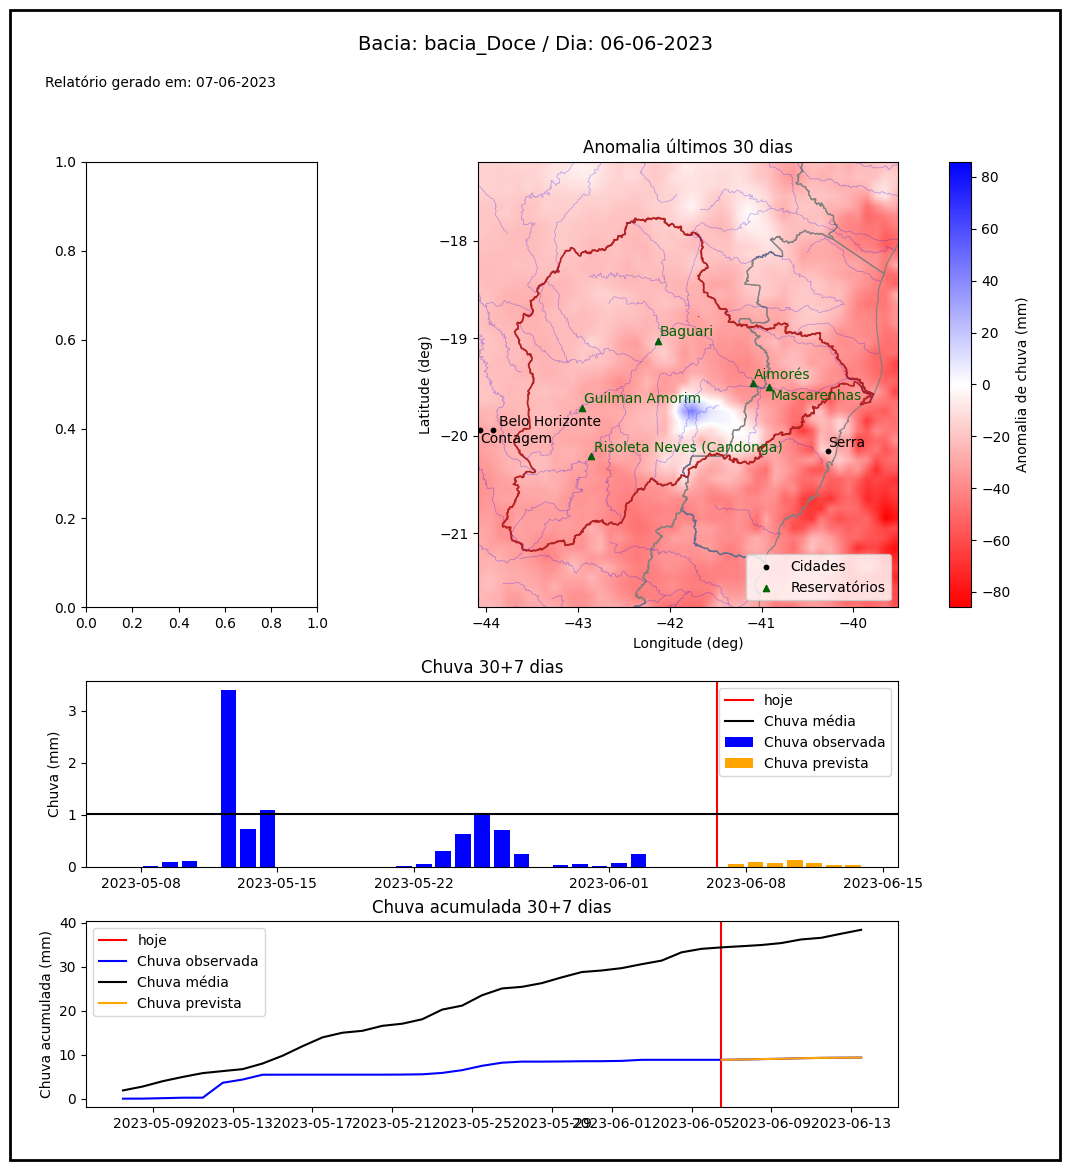

In [5]:
fig, axs, rain, avg_rain, rain_fcst, avg_rain_fcst = report.generate_report('20230606')

In [6]:
self = report
avg_rain.shape, rain.shape

((31, 691, 474), (31, 691, 474))

In [7]:
avg_rain_fcst.rio.crs

CRS.from_epsg(4326)

In [8]:
rain_ts = Downloader.get_time_series(
    rain, 
    report.shp.to_crs('epsg:4326'),
    reducer=xr.DataArray.mean
)
avg_rain_ts = Downloader.get_time_series(
    avg_rain, 
    report.shp.to_crs('epsg:4326'),
    reducer=xr.DataArray.mean
)
fcst_ts = Downloader.get_time_series(
    rain_fcst, self.shp, reducer=xr.DataArray.mean
)
avg_fcst_ts = Downloader.get_time_series(
    avg_rain_fcst, self.shp, reducer=xr.DataArray.mean
)

In [12]:
avg_fcst_ts.index = fcst_ts.index

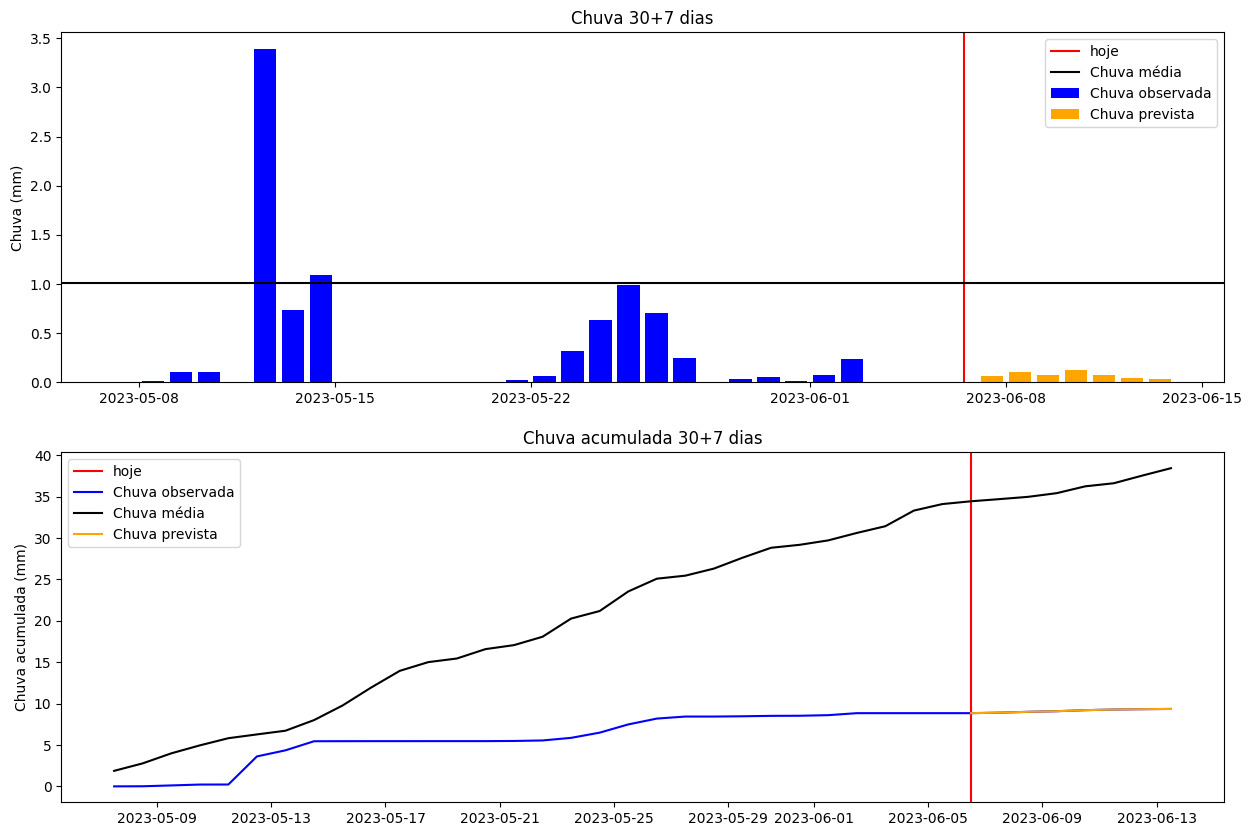

In [47]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
report.plot_charts(
    rain_cube=rain,
    avg_rain_cube=avg_rain,
    rain_fcst=rain_fcst,
    avg_rain_fcst=avg_rain_fcst,
    plt_ax1=axs[0],
    plt_ax2=axs[1]
)

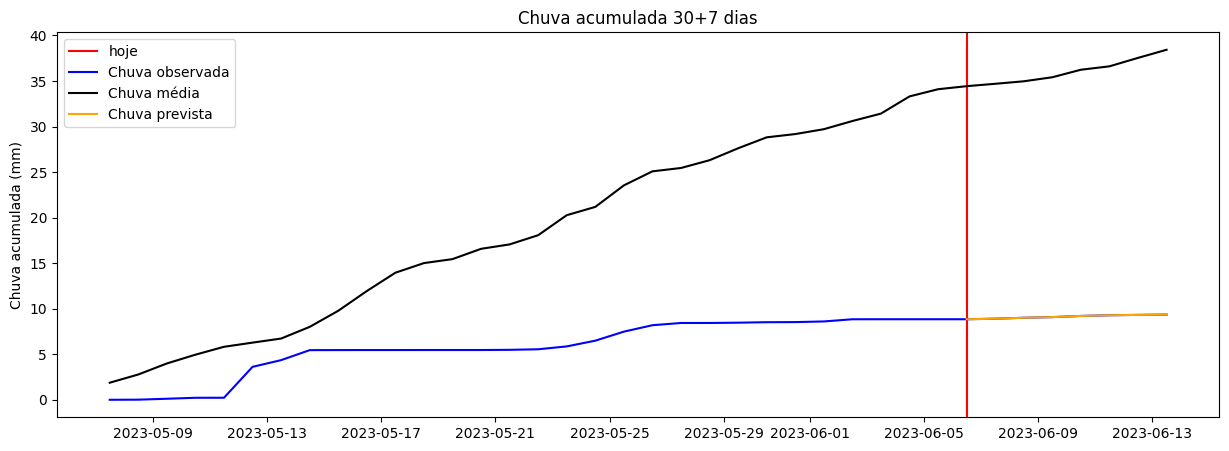

In [34]:
fig, plt_ax = plt.subplots(figsize=(15, 5))

# plot the accum chart
# create the extended rain+forecast
ext_rain_ts = pd.concat([rain_ts, fcst_ts])
plt_ax.axvline(x=rain_ts.index[-1], color='red', label='hoje')
plt_ax.plot(ext_rain_ts.index, ext_rain_ts.cumsum(), color='blue', label='Chuva observada')

ext_avg_rain_ts = pd.concat([avg_rain_ts, avg_fcst_ts])

plt_ax.plot(ext_avg_rain_ts.index, ext_avg_rain_ts.cumsum(), color='black', label='Chuva média')

# plot the forecast in another color
adjusted_fcst_ts = pd.concat([rain_ts.cumsum()[-1:], fcst_ts])
plt_ax.plot(adjusted_fcst_ts.index, adjusted_fcst_ts.cumsum(), color='orange', label='Chuva prevista')

plt_ax.set_ylabel('Chuva acumulada (mm)')
plt_ax.set_title(f"Chuva acumulada {self.days_lbk}+7 dias")

plt_ax.legend()

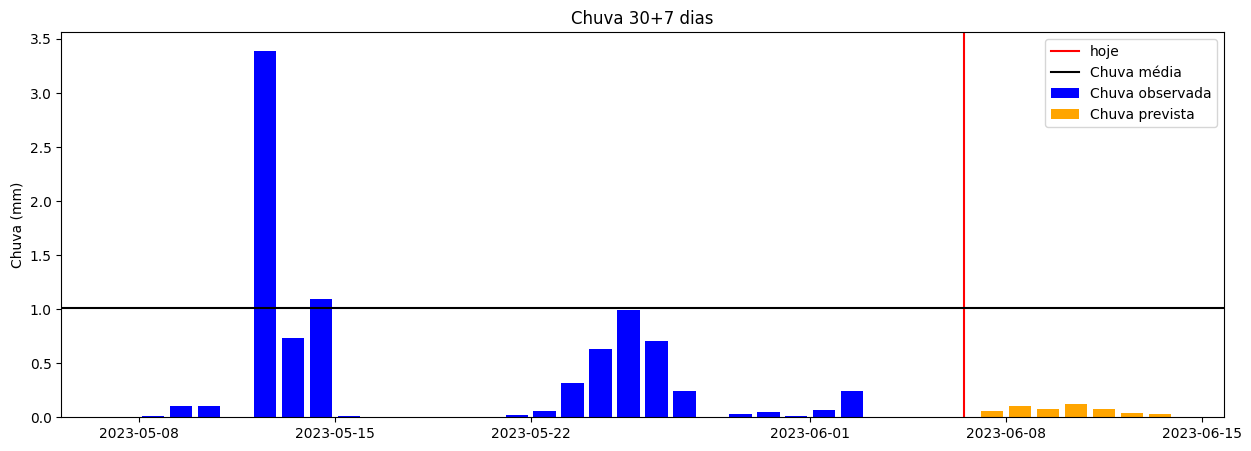

In [46]:
fig, plt_ax = plt.subplots(figsize=(15, 5))

# plot the daily chart
plt_ax.axvline(x=rain_ts.index[-1], color='red', label='hoje')
plt_ax.bar(rain_ts.index, rain_ts.values, color='blue', label='Chuva observada')
plt_ax.bar(fcst_ts.index, fcst_ts.values, color='orange', label='Chuva prevista')

ext_avg_rain_ts = pd.concat([avg_rain_ts, avg_fcst_ts])
plt_ax.axhline(y=float(ext_avg_rain_ts.mean()), color='black', label='Chuva média')


# ext_avg_rain_ts = pd.concat([avg_rain_ts, avg_fcst_ts])

# plt_ax.plot(ext_avg_rain_ts.index, ext_avg_rain_ts.cumsum(), color='black', label='Chuva média')

# # plot the forecast in another color
# adjusted_fcst_ts = pd.concat([rain_ts.cumsum()[-1:], fcst_ts])
# plt_ax.plot(adjusted_fcst_ts.index, adjusted_fcst_ts.cumsum(), color='orange', label='Chuva prevista')

plt_ax.set_ylabel('Chuva (mm)')
plt_ax.set_title(f"Chuva {self.days_lbk}+7 dias")

plt_ax.legend()

In [217]:
rain_fcst = rain_fcst.rio.set_crs('epsg:4326')
fcst_ts = Downloader.get_time_series(
    rain_fcst, 
    report.shp.to_crs('epsg:4326'),
    reducer=xr.DataArray.mean
)

In [100]:
avg_fcst_ts = Downloader.get_time_series(
    avg_rain_fcst, 
    report.shp.to_crs('epsg:4326'),
    reducer=xr.DataArray.mean
)

In [101]:
avg_fcst_ts.index = fcst_ts.index

In [104]:
avg_fcst_ts

time
2023-06-07 12:00:00    0.261806
2023-06-08 12:00:00    0.274300
2023-06-09 12:00:00    0.444486
2023-06-10 12:00:00    0.824810
2023-06-11 12:00:00    0.373024
2023-06-12 12:00:00    0.927207
2023-06-13 12:00:00    0.890456
Name: pmed, dtype: float32

In [105]:
avg_rain_ts.index.append(avg_fcst_ts.index)

DatetimeIndex(['2023-05-07 12:00:00', '2023-05-08 12:00:00',
               '2023-05-09 12:00:00', '2023-05-10 12:00:00',
               '2023-05-11 12:00:00', '2023-05-12 12:00:00',
               '2023-05-13 12:00:00', '2023-05-14 12:00:00',
               '2023-05-15 12:00:00', '2023-05-16 12:00:00',
               '2023-05-17 12:00:00', '2023-05-18 12:00:00',
               '2023-05-19 12:00:00', '2023-05-20 12:00:00',
               '2023-05-21 12:00:00', '2023-05-22 12:00:00',
               '2023-05-23 12:00:00', '2023-05-24 12:00:00',
               '2023-05-25 12:00:00', '2023-05-26 12:00:00',
               '2023-05-27 12:00:00', '2023-05-28 12:00:00',
               '2023-05-29 12:00:00', '2023-05-30 12:00:00',
               '2023-05-31 12:00:00', '2023-06-01 12:00:00',
               '2023-06-02 12:00:00', '2023-06-03 12:00:00',
               '2023-06-04 12:00:00', '2023-06-05 12:00:00',
               '2023-06-06 12:00:00', '2023-06-07 12:00:00',
               '2023-06-

In [106]:
adjusted_fcst_ts = pd.concat([rain_ts.cumsum()[-1:], fcst_ts])

In [107]:
fcst_ts[rain_ts.index[-1]] = rain_ts.cumsum()[-1]


In [108]:
fcst_ts

time
2023-06-07 12:00:00    0.061377
2023-06-08 12:00:00    0.100587
2023-06-09 12:00:00    0.074118
2023-06-10 12:00:00    0.126436
2023-06-11 12:00:00    0.075232
2023-06-12 12:00:00    0.041180
2023-06-13 12:00:00    0.030848
2023-06-06 12:00:00    8.843706
Name: forecast, dtype: float32

/tmp/ipykernel_398/2222518085.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ext_avg_rain_ts = avg_rain_ts.append(avg_fcst_ts)
/tmp/ipykernel_398/2222518085.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ext_rain_ts = rain_ts.append(fcst_ts)


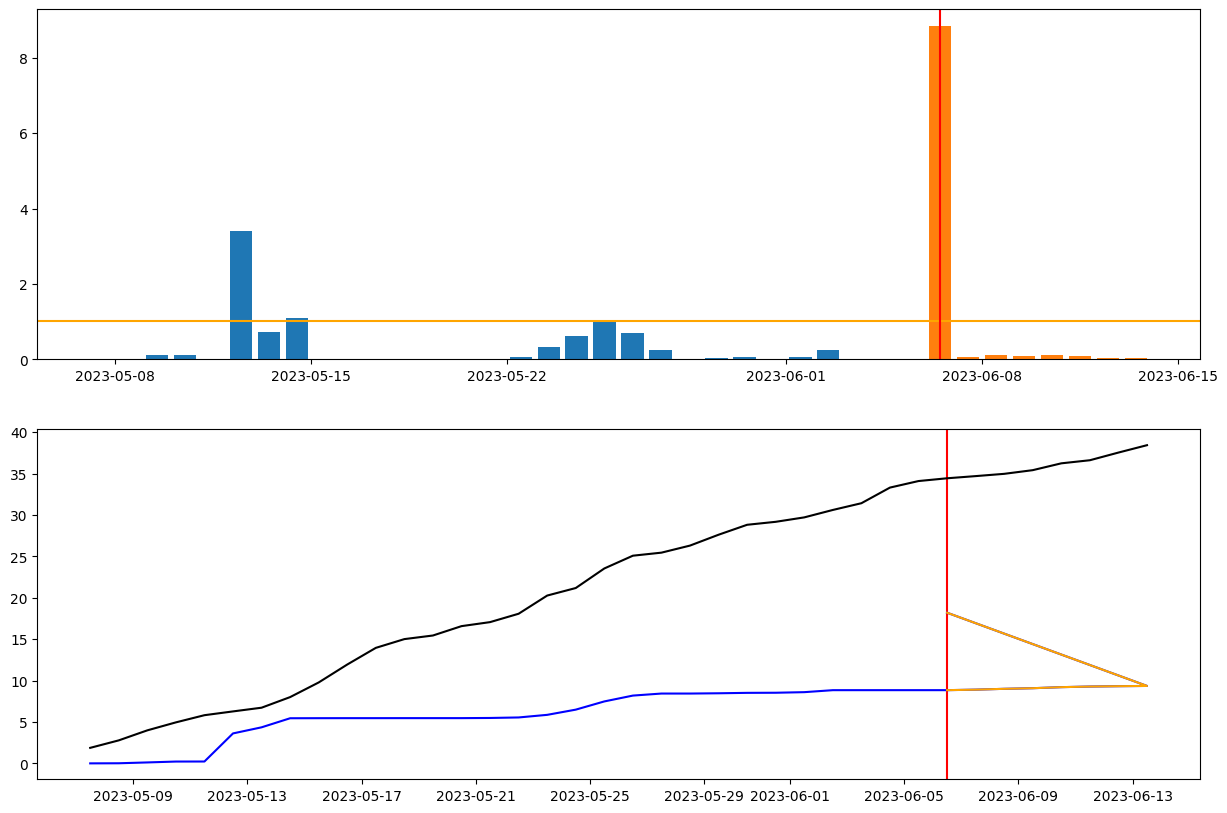

In [109]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# plot the rain
ax[0].bar(rain_ts.index, rain_ts.values)

# plot the forecast
ax[0].bar(fcst_ts.index, fcst_ts.values)

# extend the series
ext_avg_rain_ts = avg_rain_ts.append(avg_fcst_ts)

# plot the extended average
# ax[0].plot(ext_avg_rain_ts.index, ext_avg_rain_ts.values)

ax[0].axhline(y=ext_avg_rain_ts.mean(), color='orange')
ax[0].axvline(x=rain_ts.index[-1], color='red')

# plot the accum chart
# create the extended rain+forecast
ext_rain_ts = rain_ts.append(fcst_ts)
ax[1].axvline(x=rain_ts.index[-1], color='red')
ax[1].plot(ext_rain_ts.index, ext_rain_ts.cumsum(), color='blue')
ax[1].plot(ext_avg_rain_ts.index, ext_avg_rain_ts.cumsum(), color='black')

# plot the forecast in another color
adjusted_fcst_ts = pd.concat([rain_ts.cumsum()[-1:], fcst_ts])
ax[1].plot(adjusted_fcst_ts.index, adjusted_fcst_ts.cumsum(), color='orange')

<Axes: xlabel='time'>

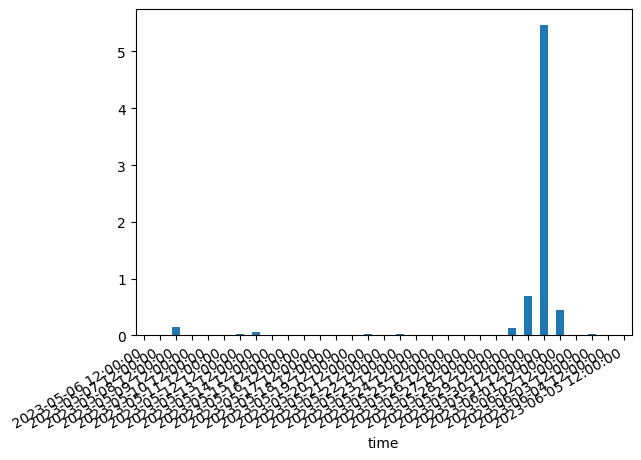

In [32]:
ax = rain_ts.plot(kind='bar')
avg_rain_ts.plot(ax=ax)

## Create the report from config

In [17]:
report_config = {
    "nome": "Doce",
    "tipo": "Mensal",
    "shp": "bacias_interesse/bacia_Doce_wgs84.shp",
    'inicio_periodo_chuvoso': 10,
    'total_meses': 23    
}
report = reporter.templates['Diario'].from_dict(
    downloader=reporter.downloader,
    mapper=reporter.mapper,
    bases_folder = '/workspaces/reports_folder/bases/',
    config=report_config 
)

In [5]:
downloader = Downloader(
    server=INPEParsers.FTPurl,
    parsers=INPEParsers.parsers,
    local_folder=download_folder
)

In [ ]:
Mapper(
    
)

In [2]:
shapes_mac = Path('/Users/cordmaur/Library/CloudStorage/OneDrive-AgênciaNacionaldeÁguas/Trabalho/SOE/COVEC/Bases/bacias de interesse SOE')
shapes_container = Path('/workspaces/bases/bacias de interesse SOE')

shapes = shapes_mac if shapes_mac.exists() else shapes_container
assert shapes.exists()

In [3]:
basins = {file.stem.split('_')[-1]: file for file in shapes.iterdir() if file.suffix == '.shp'}

In [4]:
basins

{'Doce': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Doce.shp'),
 'wgs84': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Doce_wgs84.shp'),
 'Itapecuru': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Itapecuru.shp'),
 'Jequitinhonha': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Jequitinhonha.shp'),
 'Madeira': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Madeira.shp'),
 'PortoVelho': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Madeira_em_PortoVelho.shp'),
 'Negro': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Negro.shp'),
 'Paraguai': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Paraguai.shp'),
 'ParaibaDoSul': PosixPath('/workspaces/bases/bacias de interesse SOE/bacias50k_ParaibaDoSul.shp'),
 'Parana': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Parana.shp'),
 'Pardo': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Pardo.shp'),
 'Parnaiba': PosixPa

## Creating the Reporter Object

In [6]:
reporter = RainReporter(
    server=INPEParsers.FTPurl, 
    download_folder='/workspaces/INPERainDownloader/tmp', 
    parsers=INPEParsers.parsers,
    post_processors=INPEParsers.post_processors
)


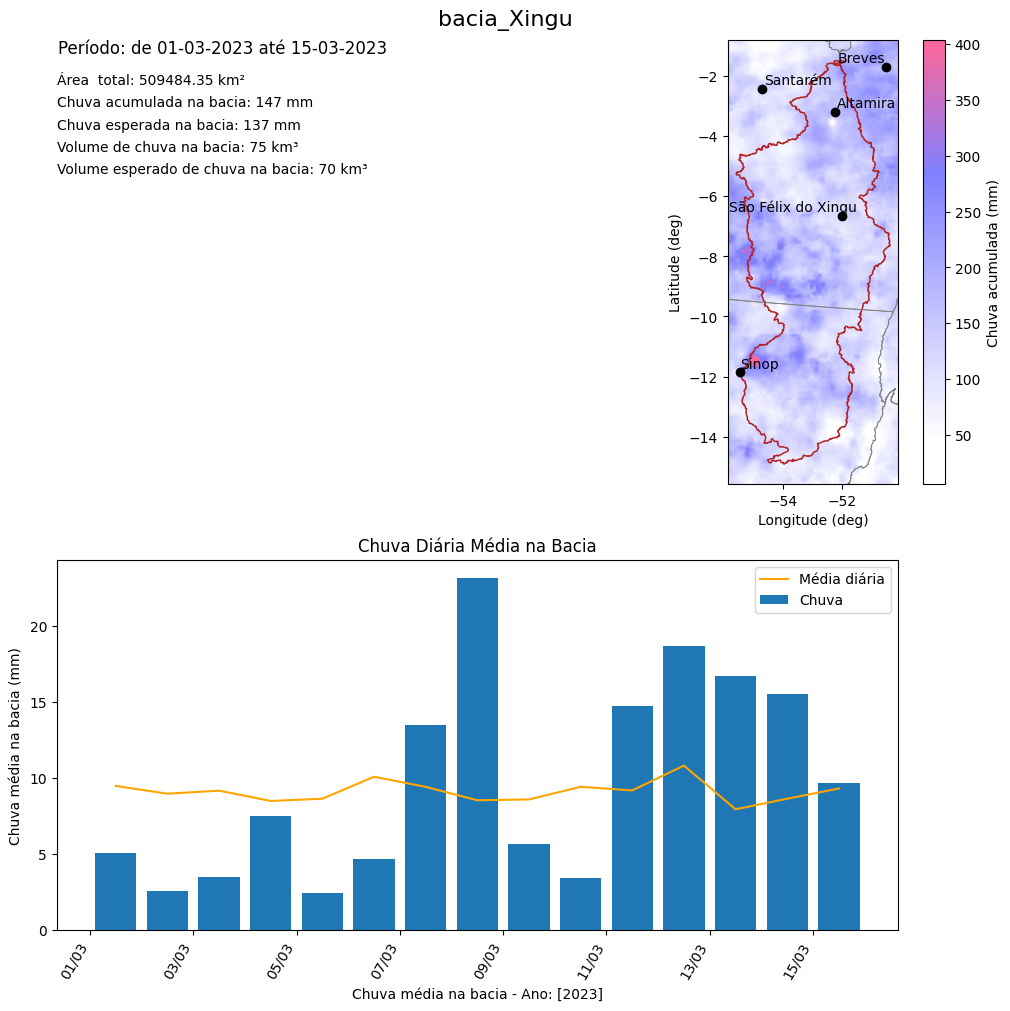

In [6]:
ax, rain, shp, cube = reporter.daily_rain_report(
    start_date='20230301',
    end_date='20230315',
    shapefile=basins['Xingu']
)

## Anomalies

In [68]:
parser = reporter.downloader.get_parser(INPETypes.DAILY_RAIN)

In [75]:
files = parser.get_range(
    start_date='20230401',
    end_date='20230418',
    local_folder='/workspaces/INPERainDownloader/tmp',
    force_download=True
)

In [76]:
files

[PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230401.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230402.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230403.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230404.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230405.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230406.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230407.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230408.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230409.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230410.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230411.grib2'),
 PosixPath('/workspaces/INPERain

In [81]:
from raindownloader.utils import GISUtil
import xarray as xr

In [87]:
xr.open_dataset('../MERGE_CPTEC_20230407.grib2')

<xarray.Dataset>
Dimensions:     (latitude: 924, longitude: 1001)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 239.9 240.0 240.1 ... 339.8 339.9 340.0
    valid_time  datetime64[ns] ...
Data variables:
    prec        (latitude, longitude) float32 ...
    prmsl       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2023-04-18T17:23 GRIB to CDM+CF via cfgrib-0.9.1...

In [89]:
xr.open_dataset(files[7])

<xarray.Dataset>
Dimensions:     (latitude: 924, longitude: 1001)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 239.9 240.0 240.1 ... 339.8 339.9 340.0
    valid_time  datetime64[ns] ...
Data variables:
    prec        (latitude, longitude) float32 ...
    prmsl       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2023-04-18T17:24 GRIB to CDM+CF via cfgrib-0.9.1...

In [90]:
cube = GISUtil.create_cube(
    files=files[:-1],
    dim_key='time'
)

In [94]:
cube = INPE.grib2_post_proc(cube)

In [97]:
accum = cube[INPETypes.DAILY_RAIN.value['var']].sum(dim="time")


In [101]:
axs, rain, lta, shp = reporter.monthly_anomaly_report(
    date_str='2023-04',
    shapefile=basins['Doce'],
)

: 

: 

In [1]:
cube

NameError: name 'cube' is not defined